# Wind speed estimation
### With temperature and wind lag
### No pca

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
#!pip install pygam
#from pygam import LinearGAM

In [20]:
# load in dataset
# read in UK t2m & NAO data
df = pd.read_csv("ERA5_hourly_UK.csv")
df.columns = ["date_time","t2m","ssrd","msl","nao", "w10","w100", "tcc", "tp"]
df.head()

,date_time,t2m,ssrd,msl,nao,w10,w100,tcc,tp
0,1979-01-01 00:00:00,-5.702784,-32767.0,1014.010319,-1.38,0.539450,1.686726,0.596991,-32767000.0
1,1979-01-01 01:00:00,-5.507162,-32767.0,1014.724101,-1.38,0.756348,1.752340,0.616364,-32767000.0
2,1979-01-01 02:00:00,-5.664224,-32767.0,1015.209416,-1.38,1.106655,2.131312,0.609257,-32767000.0
3,1979-01-01 03:00:00,-5.944852,-32767.0,1015.758926,-1.38,1.299900,2.487398,0.633477,-32767000.0
4,1979-01-01 04:00:00,-5.952020,-32767.0,1015.954954,-1.38,1.383135,2.694151,0.638393,-32767000.0


In [21]:
# add week
df["week"] = pd.to_numeric(pd.to_datetime(df.date_time).dt.strftime("%U"))

# Preprocessing

### Split Train/test

In [22]:
# calculate daily values
df.date_time = pd.to_datetime(df.date_time)
df_daily = df.groupby(df.date_time.dt.date).mean()
df_daily["t2mmax"] = t2mmax = df.t2m.groupby(df.date_time.dt.date).max()
df_daily["t2mmin"] = df.t2m.groupby(df.date_time.dt.date).min()

# set X equal to df_daily
X = df_daily
X.head()

,t2m,ssrd,msl,nao,w10,w100,tcc,tp,week,t2mmax,t2mmin
date_time,,,,,,,,,,,
1979-01-01,-4.159642,-9531.855820,1018.727490,-1.38,1.642102,3.302241,0.675312,-9.557042e+06,0,-2.207358,-5.952020
1979-01-02,-1.011778,25.708586,1022.629712,-1.38,2.915822,4.989152,0.636231,1.278941e-01,0,0.282814,-2.470000
1979-01-03,-0.129076,25.569494,1013.880059,-1.38,4.747445,7.739491,0.857288,1.156470e-01,0,1.041230,-1.418395
1979-01-04,-0.641538,20.183029,1011.304354,-1.38,3.155913,5.060900,0.934392,1.415519e-01,0,0.469106,-2.098208
1979-01-05,-2.196899,25.340972,1021.575488,-1.38,2.858333,4.329928,0.825873,9.688382e-02,0,-0.880194,-4.261743


In [23]:
# add lag features
X["t2min_previous"] = X.t2mmin.shift(1)
X["t2m_previous"] = X.t2m.shift(1)
X["t2min_next"] = X.t2mmin.shift(-1)
X["t2m_next"] = X.t2m.shift(-1)
X["w10_previous"] = X.w10.shift(1)
X["w10_next"] = X.w10.shift(-1)
X = X.fillna(0)

In [24]:
# create 24-hour t2m arrays as target variable
Y_list = []
for i in range(int(len(df)/24)):
    Y_list.append(df.w10.iloc[(i*24):(i*24+24)].values)
Y = np.array(Y_list)

# add date_time index
y = pd.DataFrame(Y,index=df_daily.index)

### Visualization of independent vars

In [25]:
#X.hist(figsize=(10,6))

Mostly normal distributions of variables of interest, except ssrd. 

In [26]:
#df.ssrd.plot(figsize=(10,5))

Remove outlier from ssrd.

In [27]:
# remove outliers
#X.ssrd[X.ssrd<-5000]=0

# produce ssrd plot
#X.ssrd.hist()



Split train/test

In [28]:
# split train/test 70/30
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state = 10,shuffle=False)

# create a dataframe of the hours for plotting purposes
X_test.index = pd.to_datetime(X_test.index)
X_test_hours = X_test.resample("1H").pad().index

### Modeling

Linear Regression

In [29]:
from sklearn.linear_model import LinearRegression

# produce linear regression
reg = LinearRegression().fit(X_train, y_train)
pred_reg = reg.predict(X_test)

In [30]:
# metrics
r2_reg = r2_score(y_test,pred_reg)
mae_reg = mean_absolute_error(y_test,pred_reg)
mse_reg = mean_squared_error(y_test,pred_reg)


print("R2-score: ",r2_reg)
print("MAE-score: ",mae_reg)
print("MSE-score: ",mse_reg)



R2-score:  0.8986259583419614
MAE-score:  0.4847649905517923
MSE-score:  0.4318833082230542


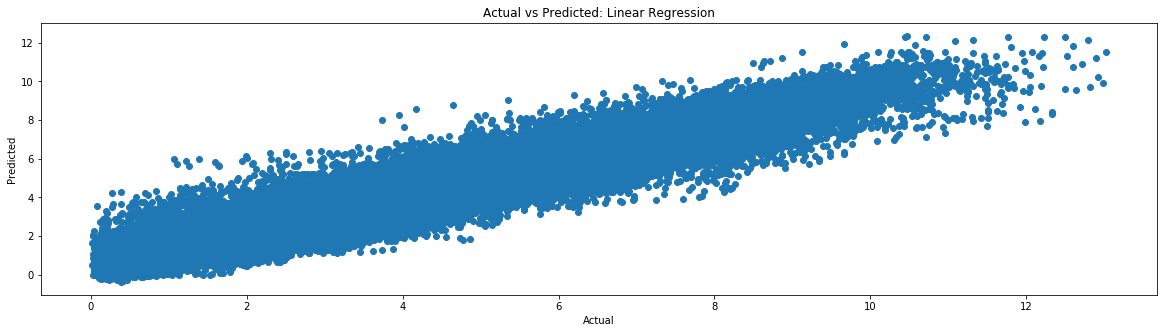

In [31]:
# plot results
plt.scatter(y_test.values.flatten(),pred_reg.flatten())
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted: Linear Regression")
plt.rcParams["figure.figsize"] = (20,5)

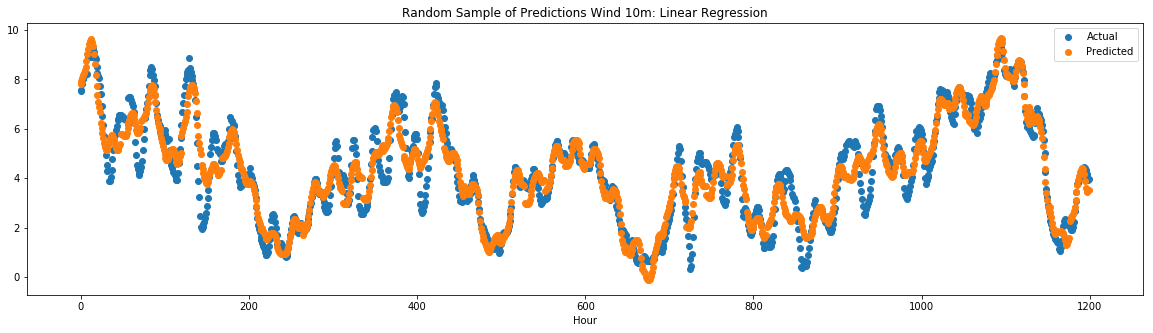

In [32]:
plt.scatter(np.arange(0,50*24,1),y_test.values[300:350])
plt.scatter(np.arange(0,50*24,1),pred_reg[300:350])
plt.xlabel("Hour")
plt.title("Random Sample of Predictions Wind 10m: Linear Regression")
plt.legend(["Actual","Predicted"])

# Random Forest

In [33]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=60).fit(X_train,y_train)
pred_rf = rf.predict(X_test)

In [34]:
# metrics
r2_rf = r2_score(y_test,pred_rf)
mae_rf = mean_absolute_error(y_test,pred_rf)
mse_rf = mean_squared_error(y_test,pred_rf)

print("R2-score: ",r2_rf)
print("MAE-score: ",mae_rf)
print("MSE-score: ",mse_rf)

R2-score:  0.8881346596187901
MAE-score:  0.5055693232649491
MSE-score:  0.47626900015763335


In [35]:
# n_estimators = []
# mae = []
# mse = []
# for i in range(1,100,10):
#     rf = RandomForestRegressor(n_estimators=i).fit(X_train,y_train)
#     pred_rf = rf.predict(X_test)
#     n_estimators.append(i)
#     mae.append(mean_absolute_error(y_test,pred_rf)) 
#     mse.append(mean_squared_error(y_test,pred_rf)) 
# n_estimators = np.array(n_estimators)
# mae = np.array(mae)
# mse = np.array(mse)

# plt.plot(n_estimators,mae)
# plt.title("Scree Plot: Random Forest")
# plt.xlabel("n_estimators")
# plt.ylabel("MAE")

# plt.plot(n_estimators,mse)
# plt.title("Scree Plot: Random Forest")
# plt.xlabel("n_estimators")
# plt.ylabel("MSE")

Maximum number of trees can be set to 100 as there is little computational cost.

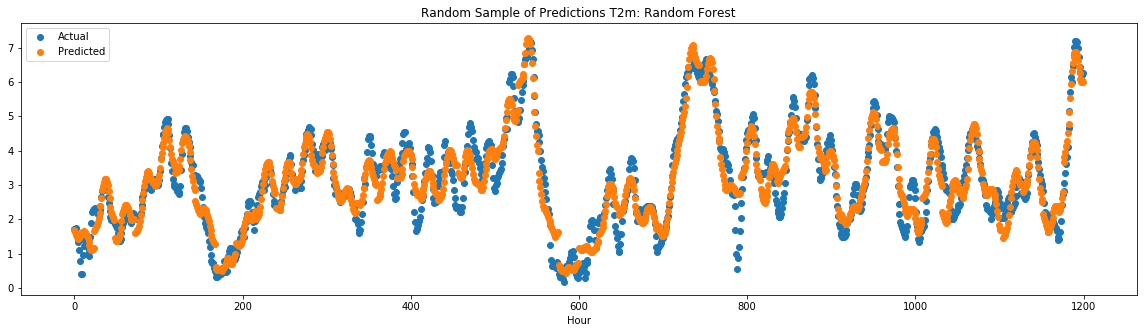

In [36]:
plt.scatter(np.arange(0,50*24,1),y_test.values[4000:4050])
plt.scatter(np.arange(0,50*24,1),pred_rf[4000:4050])
plt.xlabel("Hour")
plt.title("Random Sample of Predictions T2m: Random Forest")
plt.legend(["Actual","Predicted"])

### Analyze Best Performer

The best performer was Gradient Boosting. 

Below is a visual representation of the seasonal error.

Text(0, 0.5, 'MSE')

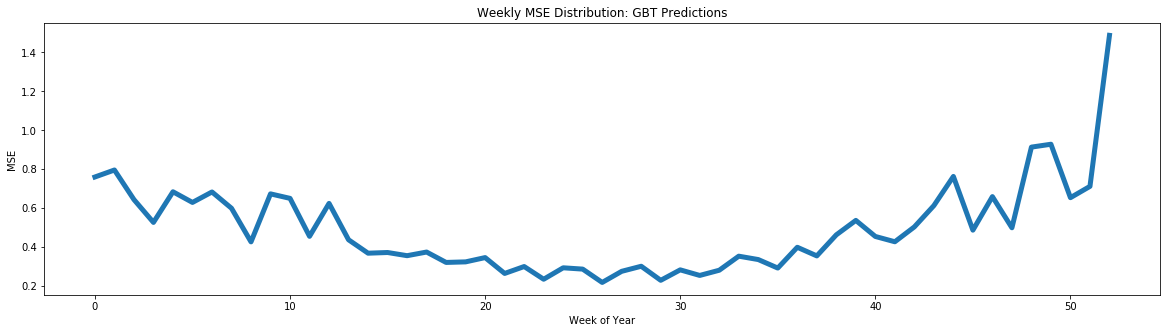

In [37]:
se = (pred_rf - y_test)**2
se.index = pd.to_datetime(se.index)
mse_by_week = se.groupby(se.index.week).mean().mean(axis=1)
plt.plot(np.arange(0,53,1),mse_by_week.values.flatten(),linewidth=5)
plt.title("Weekly MSE Distribution: GBT Predictions")
plt.xlabel("Week of Year")
plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

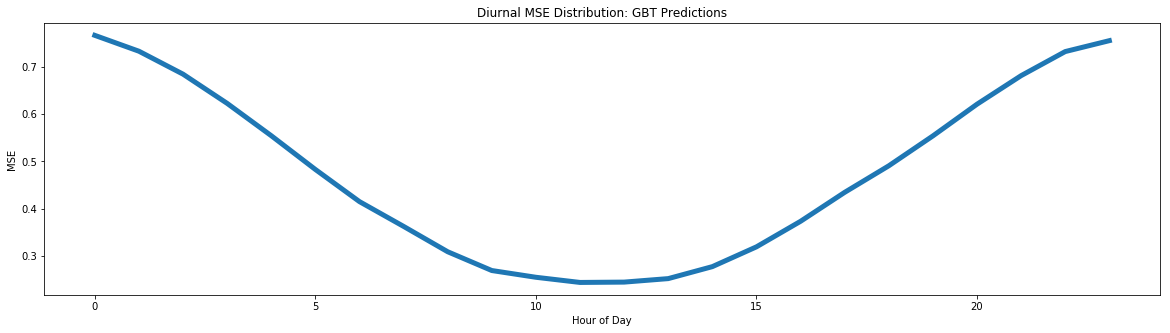

In [38]:
se = (pred_rf - y_test)**2
se.index = pd.to_datetime(se.index)
mse_by_hour = se.groupby(se.index.hour).mean()
plt.plot(np.arange(0,24,1),mse_by_hour.values.flatten(),linewidth=5)
plt.title("Diurnal MSE Distribution: GBT Predictions")
plt.xlabel("Hour of Day")
plt.ylabel("MSE")

Found that winter weeks have higher MSE in comparison to summer months.

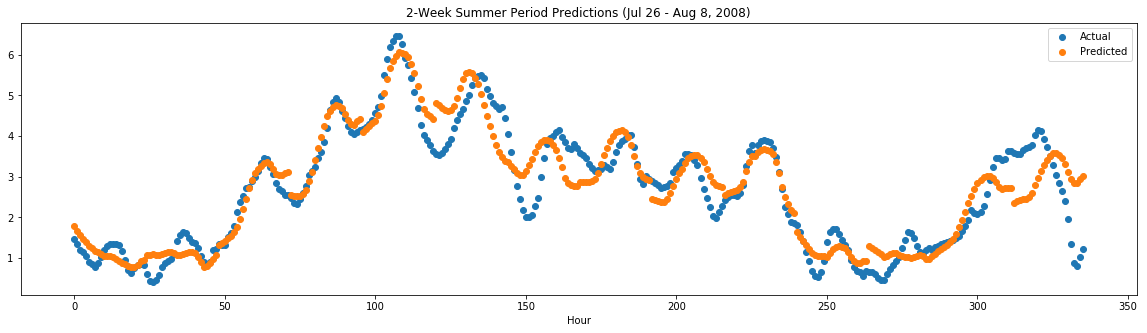

In [39]:
# generate summer/winter comparisons
y_d14_summer = y_test.iloc[60:74]
y_d14_winter = y_test.iloc[230:244]
pred_d14_summer = pred_rf[60:74]
pred_d14_winter = pred_rf[230:244]

plt.scatter(np.arange(0,14*24,1),y_d14_summer)
plt.scatter(np.arange(0,14*24,1),pred_d14_summer)
plt.xlabel("Hour")
plt.title("2-Week Summer Period Predictions (Jul 26 - Aug 8, 2008)")
plt.legend(["Actual","Predicted"])

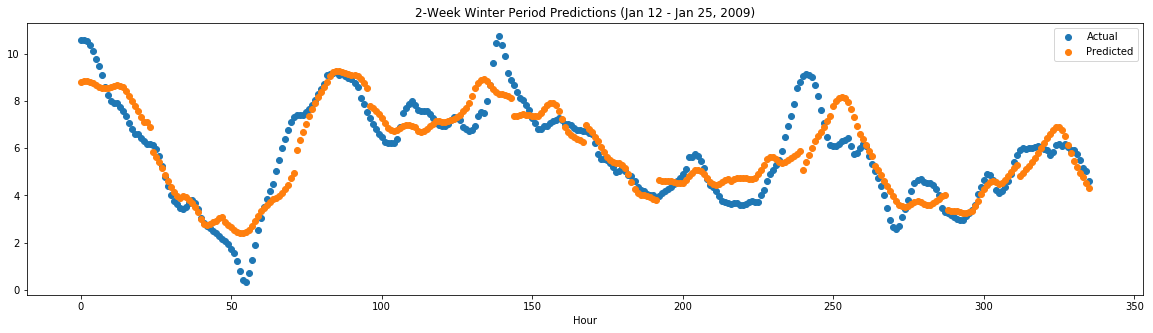

In [40]:
plt.scatter(np.arange(0,14*24,1),y_d14_winter)
plt.scatter(np.arange(0,14*24,1),pred_d14_winter)
plt.xlabel("Hour")
plt.title("2-Week Winter Period Predictions (Jan 12 - Jan 25, 2009)")
plt.legend(["Actual","Predicted"])

### Neural Networks

In [41]:
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(hidden_layer_sizes=(50, 40, 30), activation='relu', solver='adam', alpha=0.001, batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001)
nn.fit(X_train,y_train)
pred_nn = nn.predict(X_test)

In [42]:
# metrics
r2_nn = r2_score(y_test,pred_nn)
mae_nn = mean_absolute_error(y_test,pred_nn)
mse_nn = mean_squared_error(y_test,pred_nn)

print("R2-score: ",r2_nn)
print("MAE-score: ",mae_nn)
print("MSE-score: ",mse_nn)

R2-score:  0.7041526752679569
MAE-score:  0.8563760156014295
MSE-score:  1.2620770111756137


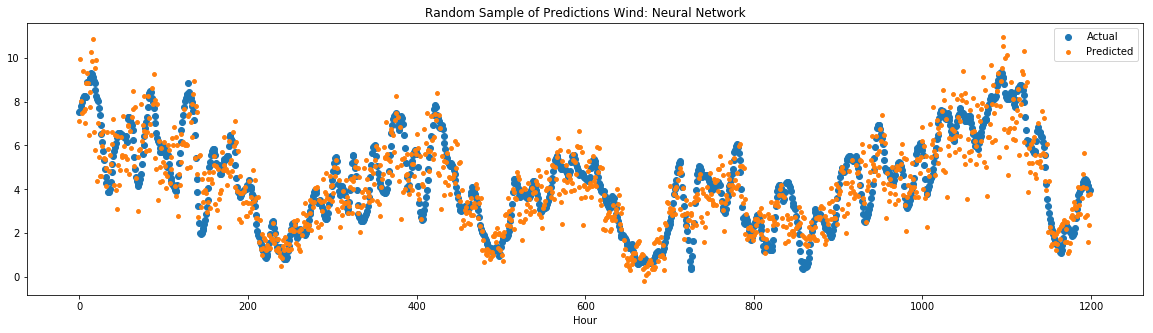

In [43]:
plt.scatter(np.arange(0,50*24,1),y_test.values[300:350])
plt.scatter(np.arange(0,50*24,1),pred_nn[300:350], s=15)


plt.xlabel("Hour")
plt.title("Random Sample of Predictions Wind: Neural Network")
plt.legend(["Actual","Predicted"])

In [44]:
def RMS_based_eval(timeseries_for_eval,field,case_no,method_str):

    ''''
    timeseries_for_eval [array] must be the appropriate length for case study evaluation 
    Case1 = 168 hours
    Case2 = 216 hours
    Case3 = 672 hours
    field [str] must either be 'T2m', 'speed10m' , or 'rsds'
    case no [str] must be either 1,2 or 3.
    method_str [str] what you'd like it referred to as.
    '''
    
    obs = np.loadtxt('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/case_studies/Case_' + case_no + '_' + field + '.dat')
    
    obs_date = np.load('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/case_studies/Case_' + case_no + '_date.npy')
    MAE = np.mean(obs - timeseries_for_eval)
    RMS = np.sqrt(np.nanmean((obs - timeseries_for_eval)**2))
    
    fig = plt.figure(figsize=(12,4))
    plt.plot(obs_date,obs,color='k',label='ERA5 obs')
    if field == 'T2m':
        plt.plot(obs_date,timeseries_for_eval,color='r',label=method_str)
        plt.ylabel('2m temperature ($^{o}$C)',fontsize=14)
        plt.title('Case study ' + case_no )
        plt.xlabel('MAE = ' + str(MAE) + ' , RMS = ' + str(RMS))
    if field == 'speed10m':
        plt.plot(obs_date,timeseries_for_eval,color='b',label=method_str)
        plt.ylabel('10m wind speed (ms$^{-1}$)',fontsize=14)
        plt.title('Case study ' + case_no)
    if field == 'rsds':)
        plt.title('Case study ' + case_no )
    plt.legend(frameon=False)
    plt.show()
    return([MAE, RMS])
        plt.plot(obs_date,timeseries_for_eval,color='gold',label=method_str)
        plt.ylabel('Surface shortwave radiation (Wm$^{-2}$)',fontsize=14

In [45]:
# index y_test to determine dates for case studies
from datetime import datetime

days = pd.to_datetime(y_test.index)
index_case1 = np.where((days>=datetime(2019,11,18)) & (days<=datetime(2019,11,24)))
input_case1_reg = pred_reg[index_case1].flatten()
input_case1 = pred_rf[index_case1].flatten()
input_case1nn = pred_nn[index_case1].flatten()


index_case2 = np.where((days>=datetime(2020,7,1)) & (days<=datetime(2020,7,9)))
input_case2_reg = pred_reg[index_case2].flatten()
input_case2 = pred_rf[index_case2].flatten()
input_case2nn = pred_nn[index_case2].flatten()


index_case3 = np.where((days>=datetime(2018,2,20)) & (days<=datetime(2018,3,19)))
input_case3_reg = pred_reg[index_case3].flatten()
input_case3 = pred_rf[index_case3].flatten()
input_case3nn = pred_nn[index_case3].flatten()


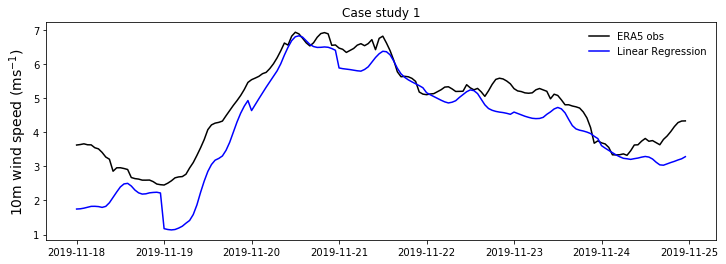

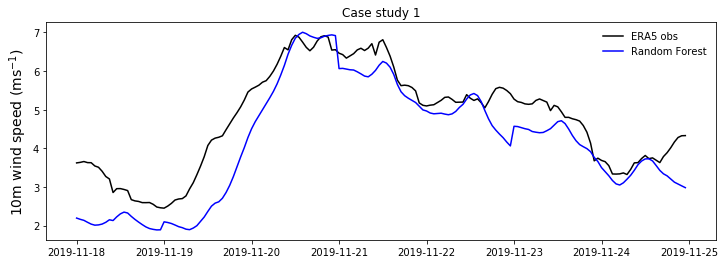

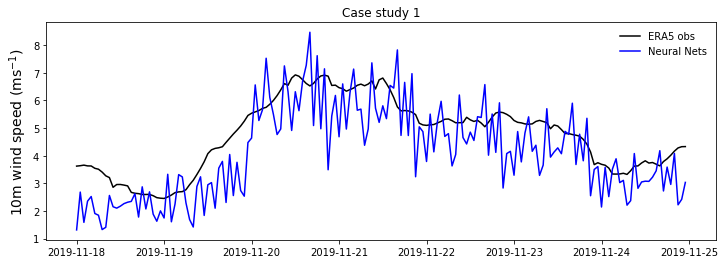

[0.6491781738842392, 1.1562416332173713]

In [46]:
RMS_based_eval(input_case1_reg,"speed10m","1","Linear Regression")
RMS_based_eval(input_case1,"speed10m","1","Random Forest")
RMS_based_eval(input_case1nn,"speed10m","1","Neural Nets")

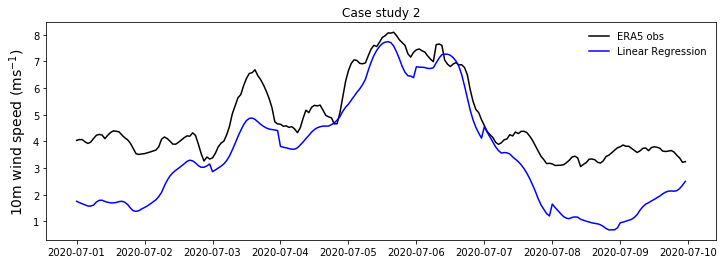

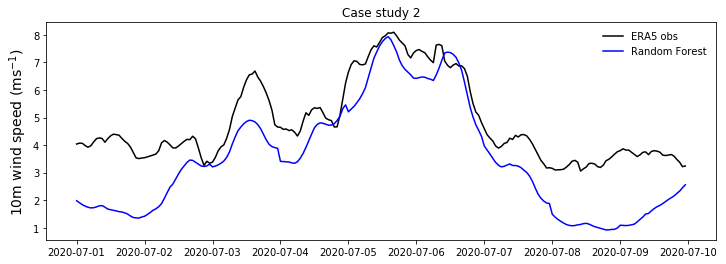

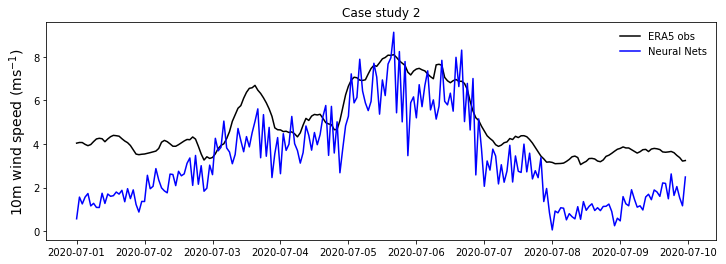

[1.5009310812509287, 1.8230714861142951]

In [47]:
RMS_based_eval(input_case2_reg,"speed10m","2","Linear Regression")
RMS_based_eval(input_case2,"speed10m","2","Random Forest")
RMS_based_eval(input_case2nn,"speed10m","2","Neural Nets")

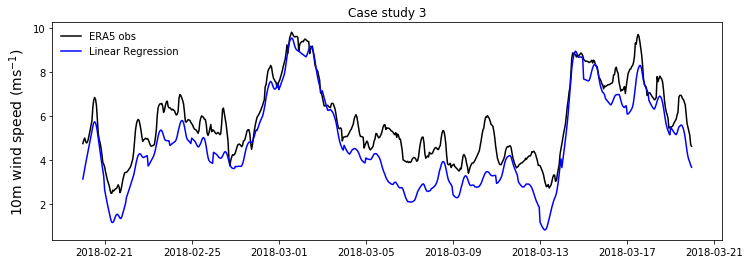

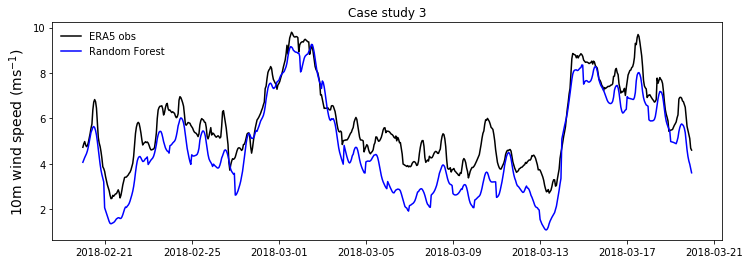

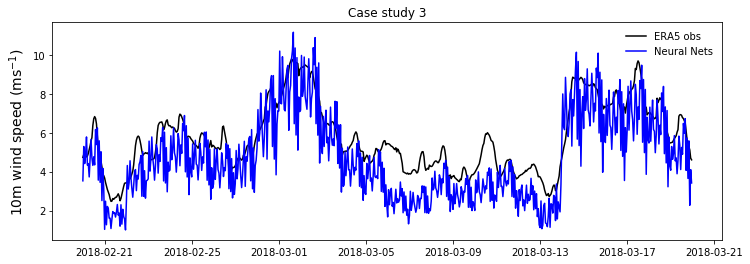

[1.035210699344319, 1.544486742340675]

In [48]:
RMS_based_eval(input_case3_reg, "speed10m","3","Linear Regression")
RMS_based_eval(input_case3,"speed10m","3","Random Forest")
RMS_based_eval(input_case3nn,"speed10m","3","Neural Nets")

t2m               0.002766
ssrd              0.009435
msl               0.007153
nao               0.006637
w10               0.851804
w100              0.008906
tcc               0.008247
tp                0.009223
week              0.006931
t2mmax            0.003603
t2mmin            0.004359
t2min_previous    0.004030
t2m_previous      0.003582
t2min_next        0.003809
t2m_next          0.003599
w10_previous      0.031441
w10_next          0.034476
dtype: float64

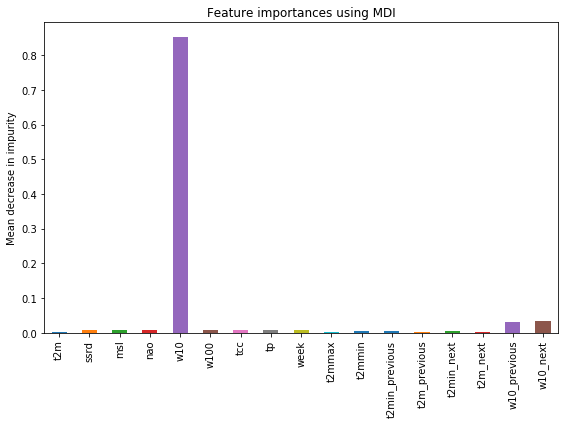

In [49]:
feature_names = X.columns
importances = rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
forest_importances.plot.bar( ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

forest_importances

In [63]:
X[X["w10"]>20]

,t2m,ssrd,msl,nao,w10,w100,tcc,tp,week,t2mmax,t2mmin,t2min_previous,t2m_previous,t2min_next,t2m_next,w10_previous,w10_next
date_time,,,,,,,,,,,,,,,,,
